# **Descripción del proyecto**
Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos.
Necesito predecir si un cliente dejará el banco pronto. Tengo los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.
Crearé un modelo con el máximo valor F1 posible. Para aprobar la revisión, necesito un valor F1 de al menos 0.59. Verificaré F1 para el conjunto de prueba.
Además, debo medir la métrica AUC-ROC y compararla con el valor F1.

# **Flujo de trabajo para el proyecto de churn en Beta Bank**


##  **Carga y exploración inicial de datos**

* Revisar el tamaño del dataset, tipos de variables y presencia de valores faltantes o inconsistencias.
* Identificar variables irrelevantes para el modelado (ej. `RowNumber`, `CustomerId`, `Surname`) y descartarlas.
* Analizar estadísticas básicas (medias, medianas, dispersión) y distribuciones de las variables principales.

---

##  **Preprocesamiento**

* **Variables categóricas:** aplicar codificación adecuada (`Geography`, `Gender`).
* **Variables numéricas:** escalar o estandarizar si el modelo lo requiere.
* **Target (`Exited`):** confirmar proporciones de clases (0 vs 1).
* Separar los datos en **entrenamiento + prueba**.
* Para LogReg se aplica OHE antes del split porque no hay riesgo de fuga.
* Para Árbol/RF se aplica OrdinalEncoder después del split para evitar fuga.

---

##  **Análisis del desequilibrio de clases**

* Calcular el porcentaje de clientes que se fueron (1) vs. los que permanecen (0).
* Entrenar modelos iniciales ``Regresión Logística``, ``Árbol de Decisión`` y ``Bosque Aleatorio`` **sin corregir desequilibrio** y calcular F1 y AUC-ROC → este es el **baseline**.
* Para esto usaré GridSearchCV con validación cruzada estratificada de 5 folds para asegurar que cada fold mantenga la proporción de clases.

---


##  Mejora de la calidad del modelo (manejo del desequilibrio de clases)
Corregir el **desequilibrio de clases (~20% churn vs. 80% no churn)** para mejorar la capacidad del modelo de detectar la clase positiva y **maximizar el F1-score** (meta ≥ 0.59).

---

### Estrategias a implementar

1. **Ajuste de pesos (`class_weight='balanced'`)**

   * Se entrenarán los modelos con y sin `class_weight='balanced'`.
   * Esta técnica ajusta la función de pérdida, dando más importancia a la clase minoritaria.
   * Modelos aplicables: **Regresión Logística, Árbol de Decisión, Random Forest**.

2. **Sobremuestreo con SMOTE**

   * Aplicaremos **SMOTE** (o SMOTENC si se mantienen categóricas sin OHE) únicamente sobre el conjunto de entrenamiento.
   * SMOTE generará ejemplos sintéticos de la clase minoritaria para equilibrar el dataset.
   * El sobremuestreo se integrará en un **pipeline** con el modelo para evitar fugas de datos (*data leakage*).

3. **Ajuste del umbral de decisión**

   * Los modelos probabilísticos (`predict_proba`) inicialmente usan un umbral de 0.5 para predecir la clase positiva.
   * Ese umbral se optimizará para **maximizar el F1-score**.
   * El umbral elegido se congelará y se evaluará en el conjunto de prueba.



##  **Selección del mejor modelo**

* Escoger el modelo con **mayor F1** en validación (criterio principal).
* Usar **AUC-ROC como métrica secundaria** para confirmar que separa bien las clases.

---

##  **Prueba final**

* Evaluar el modelo seleccionado en el conjunto de prueba.
* Reportar:

  * F1 (asegurando ≥ 0.59).
  * AUC-ROC.
  * Comparación con baseline (modelo inicial sin correcciones).


---

## **Conclusiones**

* Explicar cómo el preprocesamiento, manejo del desequilibrio y ajuste de parámetros influyeron en el desempeño.
* Justificar la elección final del modelo.


---


# 1. **Carga y exploración inicial de datos**

In [ ]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Librerías de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
# Random seed para reproducibilidad
RANDOM_SEED = 12345

In [2]:
# Importar datos
data = pd.read_csv(r'../data/Churn.csv')

In [3]:
# Análisis exploratorio y preprocesamiento de los datos
display(data.head())
display(data.info())
display(data.describe())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [4]:
''' La variable 'Tenure' tiene valores nulos, ya que creo que es una variable importante,
voy a imputar los valores nulos con la mediana y crear una nueva columna binaria que indique si el valor era nulo o no '''
data['Tenure_missing'] = (data['Tenure'].isnull()).astype(int)
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())

In [5]:
# Columnas no predictivas/identificadores:
data = data.drop(columns=['RowNumber', 'CustomerId', 'Surname'])


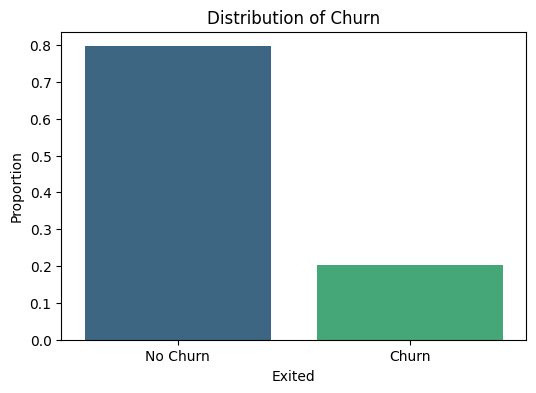

Exited
0    7963
1    2037
Name: count, dtype: int64


In [6]:
# Distribución de la variable objetivo
plt.figure(figsize=(6,4))
sns.barplot(x=data['Exited'].value_counts().index, y=data['Exited'].value_counts(normalize=True), palette='viridis', hue=data['Exited'].value_counts().index, legend=False)
plt.xticks([0,1], ['No Churn', 'Churn'], rotation=0)
plt.ylabel('Proportion')
plt.title('Distribution of Churn')
plt.show()
# Conteo de la variable objetivo
print(data['Exited'].value_counts())

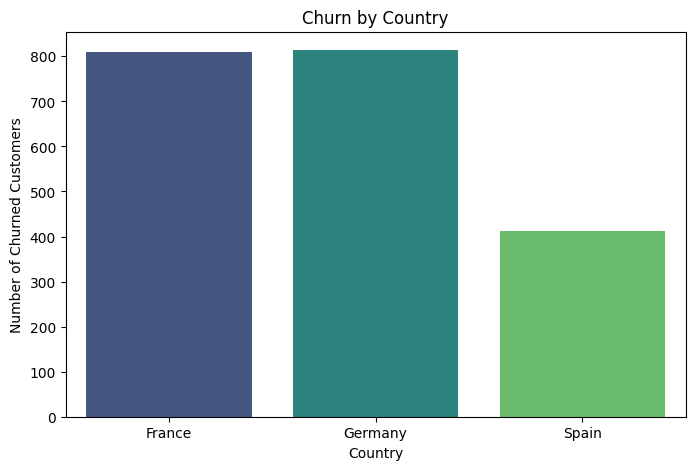

In [7]:
# Encontrar tendencias de grupos respecto a la variable objetivo


churn_per_country = data[data['Exited'] == 1].groupby('Geography')['Exited'].count()
plt.figure(figsize=(8,5))
sns.barplot(x=churn_per_country.index, y=churn_per_country.values, palette='viridis', hue=churn_per_country.index, legend=False)
plt.title('Churn by Country')
plt.ylabel('Number of Churned Customers')
plt.xlabel('Country')
plt.show()


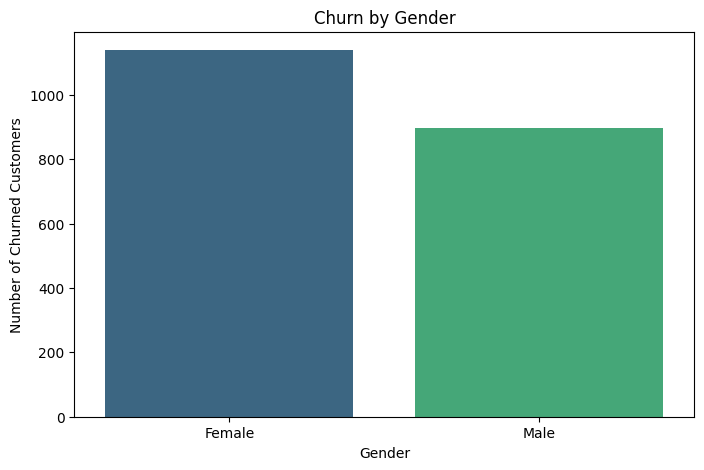

In [8]:
# Churn por género
churn_per_gender = data[data['Exited'] == 1].groupby('Gender')['Exited'].count()
plt.figure(figsize=(8,5))
sns.barplot(x=churn_per_gender.index, y=churn_per_gender.values, palette='viridis', hue=churn_per_gender.index, legend=False)
plt.title('Churn by Gender')
plt.ylabel('Number of Churned Customers')
plt.xlabel('Gender')
plt.show()

C:\Users\carlo\AppData\Local\Temp\ipykernel_25272\662777012.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_per_agegroup = data[data['Exited'] == 1].groupby('AgeGroup')['Exited'].count()


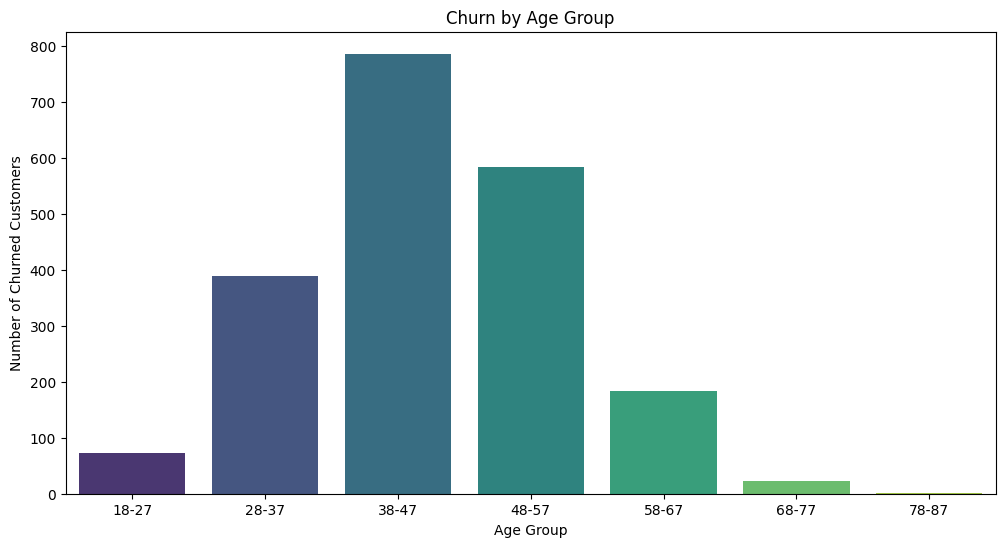

In [9]:
# Churn por rango de edad
bins = range(data.Age.min(), data.Age.max(), 10)  # de 0 a 100 en intervalos de 10
labels = [f"{i}-{i+9}" for i in bins[:-1]]
data['AgeGroup'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)
churn_per_agegroup = data[data['Exited'] == 1].groupby('AgeGroup')['Exited'].count()
plt.figure(figsize=(12,6))
sns.barplot(x=churn_per_agegroup.index, y=churn_per_agegroup.values, palette='viridis', hue=churn_per_agegroup.index, legend=False)
plt.title('Churn by Age Group')
plt.ylabel('Number of Churned Customers')
plt.xlabel('Age Group')
plt.show()


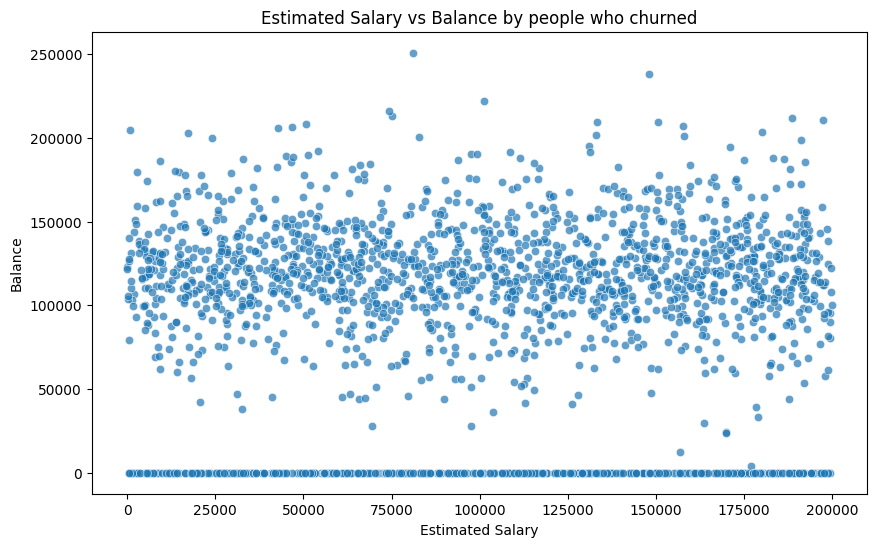

In [10]:
# Scatter plot para la relacion de salario, balance contra churn
churn = data[data['Exited'] == 1]
plt.figure(figsize=(10,6))
sns.scatterplot(data=churn, x='EstimatedSalary', y='Balance', alpha=0.7)
plt.title('Estimated Salary vs Balance by people who churned')
plt.xlabel('Estimated Salary')
plt.ylabel('Balance')
plt.show()

## Descubrimientos
* El dataset tiene 10000 filas y 14 columnas.
* La variable `Tenure` tiene valores nulos, decidí imputarlos con la mediana y crear una columna binaria que indique si el valor era nulo o no.
* Las variables `RowNumber`, `CustomerId` y `Surname` no son predictivas, las eliminé.
* La variable objetivo `Exited` está desbalanceada: 20% de churn (1) vs 80% no churn (0).
* No parece haber tendencias claras para las variables `Country` y `Gender` en relación al churn.
* En cambio parece que hay una tendencia para personas de entre 38 y 57 años que se van del banco.
* El scatter plot de `EstimatedSalary` vs `Balance` muestra que no hay una relación clara entre estas variables y el churn, pero nos muestra algo que puede ser util para el modelo y es que hay muchos clientes con balance 0 que se fueron, se podría crear una columna `Has_balance` para indicar si el cliente tiene balance o no, por el momento lo dejaré en idea.

# **Preprocesamiento**

* **Variables categóricas:** aplicar codificación adecuada (`Geography`, `Gender`).
* **Variables numéricas:** escalar o estandarizar si el modelo lo requiere.
* **Target (`Exited`):** confirmar proporciones de clases (0 vs 1).
* Separar los datos en **entrenamiento + validación + prueba**.

In [11]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Tenure_missing,AgeGroup
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1,0,38-47
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0,0,38-47
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1,0,38-47
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0,0,38-47
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0,0,38-47


In [12]:
# Remover la columna AgeGroup ya que solo se usó para análisis
data = data.drop(columns=['AgeGroup'])

In [13]:
# Transformar variables categóricas con OneHotEncoder para el modelo de regresión logística
categorical_features = ['Geography', 'Gender']
data_ohe = pd.get_dummies(data, columns=categorical_features, drop_first=True)

In [14]:
# Separar los datos en características y variable objetivo como también en entrenamiento y prueba para el modelo de regresión logística
X_ohe = data_ohe.drop(columns=['Exited'])
y_ohe = data_ohe['Exited']
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(X_ohe, y_ohe, test_size=0.2, random_state=RANDOM_SEED, stratify=y_ohe)


In [15]:
# Revisar los datos después de la codificación
display(X_train_ohe.head(), X_train_ohe.shape)
display(X_test_ohe.head(), X_test_ohe.shape)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Tenure_missing,Geography_Germany,Geography_Spain,Gender_Male
3376,644,40,4.0,77270.08,2,1,1,115800.10,0,True,False,False
1315,607,27,5.0,100912.19,1,0,0,7631.27,0,False,True,False
2552,599,46,7.0,81742.84,2,1,0,83282.21,0,False,True,False
511,632,38,6.0,86569.76,2,1,0,98090.91,0,True,False,False
1888,429,60,7.0,0.00,2,1,1,163691.48,0,False,False,True


(8000, 12)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Tenure_missing,Geography_Germany,Geography_Spain,Gender_Male
7837,850,48,2.0,0.00,1,1,0,169425.30,0,False,True,True
9505,651,28,10.0,79562.98,1,1,1,74687.37,0,False,False,True
6208,714,34,10.0,0.00,2,1,1,80234.14,0,False,False,True
5642,782,41,4.0,0.00,1,1,0,132943.88,0,False,True,False
9643,521,41,2.0,0.00,2,1,1,113089.43,0,False,False,False


(2000, 12)

In [16]:
# Separar los datos en características y variable objetivo como también en entrenamiento y prueba para luego aplicar OrdinalEncoder en los modelos de árbol de decisión y bosque aleatorio
X = data.drop(columns=['Exited'])
y = data['Exited']
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)


In [17]:
# Usar OrdinalEncoder para variables categóricas
encoder = OrdinalEncoder()
X_train_tree[categorical_features] = encoder.fit_transform(X_train_tree[categorical_features])
X_test_tree[categorical_features] = encoder.transform(X_test_tree[categorical_features])

In [18]:
# Revisar los datos después de la codificación
display(X_train_tree.head(), X_train_tree.shape)
display(X_test_tree.head(), X_test_tree.shape)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Tenure_missing
3376,644,1.0,0.0,40,4.0,77270.08,2,1,1,115800.10,0
1315,607,2.0,0.0,27,5.0,100912.19,1,0,0,7631.27,0
2552,599,2.0,0.0,46,7.0,81742.84,2,1,0,83282.21,0
511,632,1.0,0.0,38,6.0,86569.76,2,1,0,98090.91,0
1888,429,0.0,1.0,60,7.0,0.00,2,1,1,163691.48,0


(8000, 11)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Tenure_missing
7837,850,2.0,1.0,48,2.0,0.00,1,1,0,169425.30,0
9505,651,0.0,1.0,28,10.0,79562.98,1,1,1,74687.37,0
6208,714,0.0,1.0,34,10.0,0.00,2,1,1,80234.14,0
5642,782,2.0,0.0,41,4.0,0.00,1,1,0,132943.88,0
9643,521,0.0,0.0,41,2.0,0.00,2,1,1,113089.43,0


(2000, 11)

## Descubrimientos
* Realicé codificación OneHotEncoder para las variables categóricas `Geography` y `Gender` para el modelo de regresión logística.
* Realicé codificación OrdinalEncoder para las variables categóricas `Geography` y `Gender` para los modelos de árbol de decisión y bosque aleatorio.
* Separé los datos en entrenamiento y prueba con un 80% y 20% respectivamente, estratificando por la variable objetivo `Exited` para mantener la proporción de clases en ambos conjuntos.


# **Análisis del desequilibrio de clases**

* Calcular el porcentaje de clientes que se fueron (1) vs. los que permanecen (0).
* Entrenar modelos iniciales ``Regresión Logística``, ``Árbol de Decisión`` y ``Bosque Aleatorio`` **sin corregir desequilibrio** y calcular F1 y AUC-ROC → este es el **baseline**.
* Para esto usaré GridSearchCV con validación cruzada estratificada de 5 folds para asegurar que cada fold mantenga la proporción de clases.


In [19]:
# Revisar distribución de la variable objetivo en los conjuntos de entrenamiento y prueba para el modelo de regresión logística
print("Training set class distribution:")
print(y_train_ohe.value_counts())
print("\nTest set class distribution:")
print(y_test_ohe.value_counts())

Training set class distribution:
Exited
0    6370
1    1630
Name: count, dtype: int64

Test set class distribution:
Exited
0    1593
1     407
Name: count, dtype: int64


In [20]:
# Revisar distribución de la variable objetivo en los conjuntos de entrenamiento y prueba para el modelo de árbol de decisión y bosque aleatorio
print("Training set class distribution:")
print(y_train_tree.value_counts())
print("\nTest set class distribution:")
print(y_test_tree.value_counts())

Training set class distribution:
Exited
0    6370
1    1630
Name: count, dtype: int64

Test set class distribution:
Exited
0    1593
1     407
Name: count, dtype: int64


In [21]:
# Función para explicar la matriz de confusión
def explain_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

# Extraer valores
    tn, fp, fn, tp = cm.ravel()

# Imprimir interpretación
    print(f"Verdaderos Negativos (VN) - Clientes que se quedaron y el modelo predijo que se quedaban: {tn}")
    print(f"Falsos Positivos (FP)   - Clientes que se quedaron pero el modelo predijo que se iban: {fp}")
    print(f"Falsos Negativos (FN)   - Clientes que se fueron pero el modelo predijo que se quedaban: {fn}")
    print(f"Verdaderos Positivos (VP) - Clientes que se fueron y el modelo predijo que se iban: {tp}")
   
    

In [22]:
# Configuración de validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [23]:
# Empezaré entrenando modelos iniciales sin corregir el desequilibrio de clases para establecer un baseline
# 1. Regresión Logística
# Pipeline para regresión logística
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=RANDOM_SEED, max_iter=1000))
])

# Definir hiperparámetros para grid search
param_grid_lr = {
    'model__solver': ['liblinear'],
    'model__penalty': ['l1', 'l2'],
    'model__C': [0.01, 0.1, 1, 10, 100],
}
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=cv, scoring='f1', n_jobs=-1)
grid_search_lr.fit(X_train_ohe, y_train_ohe)
best_lr = grid_search_lr.best_estimator_
best_lr_params = grid_search_lr.best_params_

print(f'Mejores hiperparámetros Regresión Logística: {best_lr_params}')
print(f'F1 en conjunto de entrenamiento: {grid_search_lr.best_score_:.4f}')
print(f'AUC-ROC en conjunto de entrenamiento: {roc_auc_score(y_train_ohe, best_lr.predict_proba(X_train_ohe)[:,1]):.4f}')

Mejores hiperparámetros Regresión Logística: {'model__C': 10, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
F1 en conjunto de entrenamiento: 0.3234
AUC-ROC en conjunto de entrenamiento: 0.7637


In [24]:
# Evaluar en el conjunto de prueba
y_pred_lr = best_lr.predict(X_test_ohe)
print(f'F1 en conjunto de prueba: {f1_score(y_test_ohe, y_pred_lr):.4f}')
print(f'AUC-ROC en conjunto de prueba: {roc_auc_score(y_test_ohe, best_lr.predict_proba(X_test_ohe)[:,1]):.4f}')

F1 en conjunto de prueba: 0.3091
AUC-ROC en conjunto de prueba: 0.7769


El modelo identifica bien a los clientes que se quedan, pero falla al detectar la mayoría de los que se van, como muestran los 322 falsos negativos


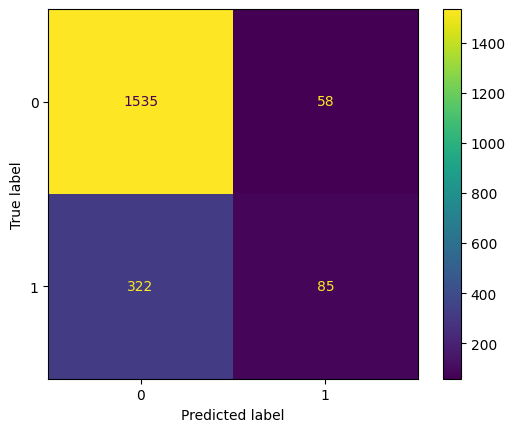

In [25]:
# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(best_lr, X_test_ohe, y_test_ohe)
print('El modelo identifica bien a los clientes que se quedan, pero falla al detectar la mayoría de los que se van, como muestran los 322 falsos negativos')

In [26]:
# Procedemos con arbol de decisión
tree = DecisionTreeClassifier(random_state=RANDOM_SEED)
tree_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(1, 11)),   
    'min_samples_split': list(range(2, 11,2)),    
    'min_samples_leaf': list(range(1, 11,2))      
}
grid_search_tree = GridSearchCV(tree, tree_params, cv=cv, scoring='f1', n_jobs=-1, error_score='raise')
grid_search_tree.fit(X_train_tree, y_train_tree)
best_tree = grid_search_tree.best_estimator_
best_tree_params = grid_search_tree.best_params_
print(f'Mejores hiperparámetros Árbol de Decisión: {best_tree_params}')
print(f'F1 en conjunto de entrenamiento: {grid_search_tree.best_score_:.4f}')
print(f'AUC-ROC en conjunto de entrenamiento: {roc_auc_score(y_train_tree, best_tree.predict_proba(X_train_tree)[:,1]):.4f}')

Mejores hiperparámetros Árbol de Decisión: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 7, 'min_samples_split': 2}
F1 en conjunto de entrenamiento: 0.5494
AUC-ROC en conjunto de entrenamiento: 0.9045


In [27]:
# Evaluar en el conjunto de prueba
y_pred_tree = best_tree.predict(X_test_tree)
print(f'F1 en conjunto de prueba: {f1_score(y_test_tree, y_pred_tree):.4f}')
print(f'AUC-ROC en conjunto de prueba: {roc_auc_score(y_test_tree, best_tree.predict_proba(X_test_tree)[:,1]):.4f}')

F1 en conjunto de prueba: 0.5457
AUC-ROC en conjunto de prueba: 0.8058


Verdaderos Negativos (VN) - Clientes que se quedaron y el modelo predijo que se quedaban: 1499
Falsos Positivos (FP)   - Clientes que se quedaron pero el modelo predijo que se iban: 94
Falsos Negativos (FN)   - Clientes que se fueron pero el modelo predijo que se quedaban: 219
Verdaderos Positivos (VP) - Clientes que se fueron y el modelo predijo que se iban: 188


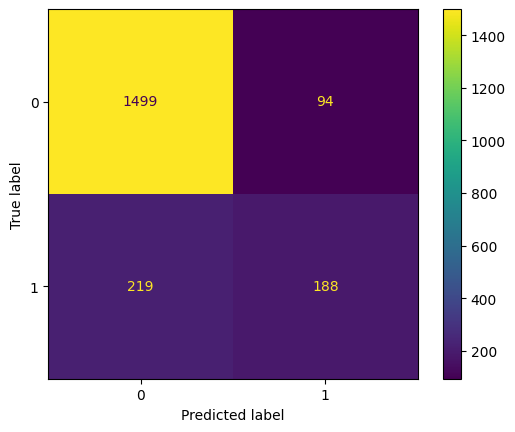

In [28]:
# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(best_tree, X_test_tree, y_test_tree)
explain_confusion_matrix(y_test_tree, y_pred_tree)

In [29]:
# Seguimos con bosque aleatorio
forest = RandomForestClassifier(random_state=RANDOM_SEED)
forest_params = {
    'n_estimators': list(range(10, 101, 10)),
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(1, 11)),   
    'min_samples_split':list(range(2,11,2)),   
    'min_samples_leaf': list(range(1,8,2))   
}
grid_search_forest = GridSearchCV(forest, forest_params, cv=cv, scoring='f1', n_jobs=-1, error_score='raise')
grid_search_forest.fit(X_train_tree, y_train_tree)
best_forest = grid_search_forest.best_estimator_
best_forest_params = grid_search_forest.best_params_
print(f'Mejores hiperparámetros Bosque Aleatorio: {best_forest_params}')
print(f'F1 en conjunto de entrenamiento: {grid_search_forest.best_score_:.4f}')
print(f'AUC-ROC en conjunto de entrenamiento: {roc_auc_score(y_train_tree, best_forest.predict_proba(X_train_tree)[:,1]):.4f}')

Mejores hiperparámetros Bosque Aleatorio: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
F1 en conjunto de entrenamiento: 0.5533
AUC-ROC en conjunto de entrenamiento: 0.9383


In [30]:
# Evaluar en el conjunto de prueba
y_pred_forest = best_forest.predict(X_test_tree)
print(f'F1 en conjunto de prueba: {f1_score(y_test_tree, y_pred_forest):.4f}')
print(f'AUC-ROC en conjunto de prueba: {roc_auc_score(y_test_tree, best_forest.predict_proba(X_test_tree)[:,1]):.4f}')

F1 en conjunto de prueba: 0.5342
AUC-ROC en conjunto de prueba: 0.8656


Verdaderos Negativos (VN) - Clientes que se quedaron y el modelo predijo que se quedaban: 1550
Falsos Positivos (FP)   - Clientes que se quedaron pero el modelo predijo que se iban: 43
Falsos Negativos (FN)   - Clientes que se fueron pero el modelo predijo que se quedaban: 243
Verdaderos Positivos (VP) - Clientes que se fueron y el modelo predijo que se iban: 164


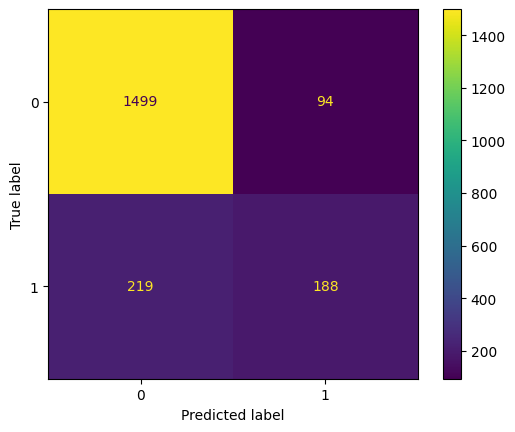

In [31]:
# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(best_tree, X_test_tree, y_test_tree)
explain_confusion_matrix(y_test_tree, y_pred_forest)

## Descubrimientos 

* **La regresión logística, sin tratar el desbalance, no supera el F1 mínimo de 0.59.**
* AUC-ROC muestra que hay potencial, pero para que el modelo sea útil, **necesito corregir el desequilibrio de clases** (siguiente paso del proyecto).
* El árbol sin balanceo aún no alcanza F1=0.59; aplicaré class_weight/re-muestreo y ajuste de umbral en el siguiente paso.
* El bosque aleatorio logra el mejor equilibrio entre F1 (≈0.55) y AUC-ROC (≈0.81). Aún no alcanza el mínimo de F1=0.59, pero ya está mucho más cerca. El Random Forest ya muestra que sí hay patrones útiles en los datos, pero el desequilibrio de clases limita el recall de la clase 1.
* Estrategias a aplicar en el **paso 4**:

  1. **class_weight='balanced'** en los modelos.
  2. Técnicas de re-muestreo (oversampling, undersampling).
  3. Ajuste del **umbral de decisión** en lugar de usar 0.5.




# Mejora de la calidad del modelo (manejo del desequilibrio de clases)
Corregir el **desequilibrio de clases (~20% churn vs. 80% no churn)** para mejorar la capacidad del modelo de detectar la clase positiva y **maximizar el F1-score** (meta ≥ 0.59).
Estrategias a implementar:

1. **Ajuste de pesos (`class_weight='balanced'`)**

   * Se entrenarán los modelos con y sin `class_weight='balanced'`.
   * Esta técnica ajusta la función de pérdida, dando más importancia a la clase minoritaria.
   * Modelos aplicables: **Regresión Logística, Árbol de Decisión, Random Forest**.

2. **Sobremuestreo con SMOTE**

   * Aplicaremos **SMOTE** (o SMOTENC si se mantienen categóricas sin OHE) únicamente sobre el conjunto de entrenamiento.
   * SMOTE generará ejemplos sintéticos de la clase minoritaria para equilibrar el dataset.
   * El sobremuestreo se integrará en un **pipeline** con el modelo para evitar fugas de datos (*data leakage*).

3. **Ajuste del umbral de decisión**

   * Los modelos probabilísticos (`predict_proba`) inicialmente usan un umbral de 0.5 para predecir la clase positiva.
   * Ese umbral se optimizará para **maximizar el F1-score**.
   * El umbral elegido se congelará y se evaluará en el conjunto de prueba.


In [32]:
# Funcion para barrer muchos umbrales y encontrar el que maximiza el F1-score
def best_umbral(probs_val, y_val):
    thresholds = np.linspace(0.01, 0.99, 99)
    f1_scores = []

    for t in thresholds:
        y_val_pred = (probs_val >= t).astype(int)
        f1_scores.append(f1_score(y_val, y_val_pred))

    best_idx = int(np.argmax(f1_scores))
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    return print(f"Mejor umbral (por F1): {best_threshold:.3f}  |  F1 en validación: {best_f1:.4f}")


In [33]:
# Entrenaré de nuevo los modelos aplicando class_weight='balanced' para corregir el desequilibrio de clases
# 1. Regresión Logística con class_weight='balanced'

pipeline_lr_balanced = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(class_weight='balanced'))
])

param_grid_lr_balanced =  {
    'model__solver': ['liblinear'],
    'model__penalty': ['l1', 'l2'],
    'model__C': [0.01, 0.1, 1, 10, 100],
}
grid_lr_balanced = GridSearchCV(pipeline_lr_balanced, param_grid_lr_balanced, cv=cv, scoring='f1', n_jobs=-1)
grid_lr_balanced.fit(X_train_ohe, y_train_ohe)
best_lr_balanced = grid_lr_balanced.best_estimator_
best_lr_balanced_params = grid_lr_balanced.best_params_
lr_train_balanced_probs = best_lr_balanced.predict_proba(X_train_ohe)[:,1]
print(f'Mejores hiperparámetros Regresión Logística (balanced): {best_lr_balanced_params}')
print(f'F1 en conjunto de entrenamiento: {grid_lr_balanced.best_score_:.4f}')
print(f'AUC-ROC en conjunto de entrenamiento: {roc_auc_score(y_train_ohe, lr_train_balanced_probs):.4f}')

Mejores hiperparámetros Regresión Logística (balanced): {'model__C': 0.01, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
F1 en conjunto de entrenamiento: 0.4882
AUC-ROC en conjunto de entrenamiento: 0.7670


In [34]:
# Evaluar en el conjunto de prueba
y_pred_lr_balanced = best_lr_balanced.predict(X_test_ohe)
print(f'F1 en conjunto de prueba: {f1_score(y_test_ohe, y_pred_lr_balanced):.4f}')
lr_test_balanced_probs = best_lr_balanced.predict_proba(X_test_ohe)[:,1]
print(f'AUC-ROC en conjunto de prueba: {roc_auc_score(y_test_ohe, lr_test_balanced_probs):.4f}')

F1 en conjunto de prueba: 0.5066
AUC-ROC en conjunto de prueba: 0.7841


In [35]:
# Buscar el umbral que aumente el valor de F1
best_umbral(lr_test_balanced_probs, y_test_ohe)

Mejor umbral (por F1): 0.580  |  F1 en validación: 0.5337


Verdaderos Negativos (VN) - Clientes que se quedaron y el modelo predijo que se quedaban: 1117
Falsos Positivos (FP)   - Clientes que se quedaron pero el modelo predijo que se iban: 476
Falsos Negativos (FN)   - Clientes que se fueron pero el modelo predijo que se quedaban: 102
Verdaderos Positivos (VP) - Clientes que se fueron y el modelo predijo que se iban: 305


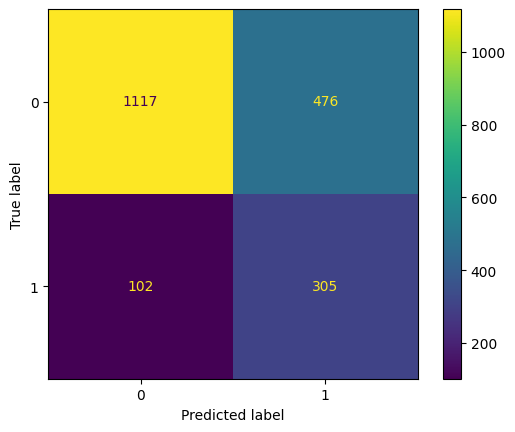

In [36]:
# Aplicar el mejor umbral y obtener la Matriz de confusión
best_lr_threshold = 0.5066
y_pred_lr_thr = (lr_test_balanced_probs >= best_lr_threshold).astype(int)
cm = confusion_matrix(y_test_ohe, y_pred_lr_thr)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
explain_confusion_matrix(y_test_ohe, y_pred_lr_thr)

In [37]:
# Seguimos con el árbol de decisión con class_weight='balanced'
tree_balanced = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_SEED)
tree_balanced_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(1, 11)),   
    'min_samples_split': list(range(2, 11,2)),    
    'min_samples_leaf': list(range(1, 11,2))      
}
grid_balanced_tree = GridSearchCV(tree_balanced, tree_balanced_params, cv=cv, scoring='f1', n_jobs=-1, error_score='raise')
grid_balanced_tree.fit(X_train_tree, y_train_tree)
best_balanced_tree = grid_balanced_tree.best_estimator_
best_balanced_tree_params = grid_balanced_tree.best_params_
print(f'Mejores hiperparámetros Árbol de Decisión (balanced): {best_balanced_tree_params}')
print(f'F1 en conjunto de entrenamiento: {grid_balanced_tree.best_score_:.4f}')
print(f'AUC-ROC en conjunto de entrenamiento: {roc_auc_score(y_train_tree, best_balanced_tree.predict_proba(X_train_tree)[:,1]):.4f}')

Mejores hiperparámetros Árbol de Decisión (balanced): {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 7, 'min_samples_split': 2}
F1 en conjunto de entrenamiento: 0.5643
AUC-ROC en conjunto de entrenamiento: 0.8457


In [38]:
# Evaluar en el conjunto de prueba
y_pred_balanced_tree = best_balanced_tree.predict(X_test_tree)
print(f'F1 en conjunto de prueba: {f1_score(y_test_tree, y_pred_balanced_tree):.4f}')
print(f'AUC-ROC en conjunto de prueba: {roc_auc_score(y_test_tree, best_balanced_tree.predict_proba(X_test_tree)[:,1]):.4f}')

F1 en conjunto de prueba: 0.5636
AUC-ROC en conjunto de prueba: 0.8378


In [39]:
# Buscar el mejor umbral para árbol de decisión
tree_probs = best_balanced_tree.predict_proba(X_test_tree)[:,1]
best_umbral(tree_probs, y_test_tree)
print(f'AUC-ROC con el nuevo umbral {roc_auc_score(y_test_tree, y_pred_tree)}')

Mejor umbral (por F1): 0.580  |  F1 en validación: 0.5914
AUC-ROC con el nuevo umbral 0.701454150606693


Verdaderos Negativos (VN) - Clientes que se quedaron y el modelo predijo que se quedaban: 1326
Falsos Positivos (FP)   - Clientes que se quedaron pero el modelo predijo que se iban: 267
Falsos Negativos (FN)   - Clientes que se fueron pero el modelo predijo que se quedaban: 124
Verdaderos Positivos (VP) - Clientes que se fueron y el modelo predijo que se iban: 283
AUC-ROC con el nuevo umbral 0.7639


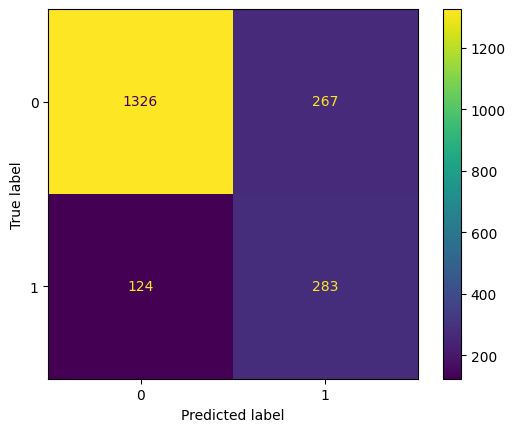

In [40]:
# Aplicar el mejor umbral y obtener la Matriz de confusión
best_tree_threshold = 0.58
y_pred_tree_threshold = (tree_probs >= best_tree_threshold).astype(int)
cm = confusion_matrix(y_test_tree, y_pred_tree_threshold)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
explain_confusion_matrix(y_test_tree, y_pred_tree_threshold)
print(f'AUC-ROC con el nuevo umbral {roc_auc_score(y_test_tree, y_pred_tree_threshold):.4f}')


In [41]:
# Seguimos con el bosque aleatorio
forest_balanced = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_SEED)
param_forest_bal = {
    'n_estimators': list(range(10, 101, 10)),
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(1, 11)),   
    'min_samples_split':list(range(2,11,2)),   
    'min_samples_leaf': list(range(1,8,2))   
}

grid_forest_bal = GridSearchCV(estimator=forest_balanced, cv=cv, param_grid=param_forest_bal, scoring='f1', n_jobs=-1)
grid_forest_bal.fit(X_train_tree, y_train_tree)
best_forest_balanced = grid_forest_bal.best_estimator_
best_forest_balanced_params = grid_forest_bal.best_params_
print(f'Mejores hiperparámetros Bosque Aleatorio (balanced): {best_forest_balanced_params}')
print(f'F1 en conjunto de entrenamiento: {grid_forest_bal.best_score_:.4f}')
print(f'AUC-ROC en conjunto de entrenamiento: {roc_auc_score(y_train_tree, best_forest_balanced.predict_proba(X_train_tree)[:,1]):.4f}')


Mejores hiperparámetros Bosque Aleatorio (balanced): {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 80}
F1 en conjunto de entrenamiento: 0.6115
AUC-ROC en conjunto de entrenamiento: 0.9514


In [42]:
# Evaluación el el conjunto de entrenamiento
y_pred_forest_bal = best_forest_balanced.predict(X_test_tree)
forest_probs = best_forest_balanced.predict_proba(X_test_tree)[:,1]
print(f'F1 en el conjunto de prueba: {f1_score(y_pred_forest_bal, y_test_tree):.4f}')
print(f'AUC-ROC en el conjunto de prueba: {roc_auc_score(y_test_tree, forest_probs):.4f}')

F1 en el conjunto de prueba: 0.6330
AUC-ROC en el conjunto de prueba: 0.8627


In [43]:
# Encontrar el mejor umbral para bosque aleatorio
best_umbral(forest_probs, y_test_tree)

Mejor umbral (por F1): 0.480  |  F1 en validación: 0.6341


Verdaderos Negativos (VN) - Clientes que se quedaron y el modelo predijo que se quedaban: 1404
Falsos Positivos (FP)   - Clientes que se quedaron pero el modelo predijo que se iban: 189
Falsos Negativos (FN)   - Clientes que se fueron pero el modelo predijo que se quedaban: 131
Verdaderos Positivos (VP) - Clientes que se fueron y el modelo predijo que se iban: 276


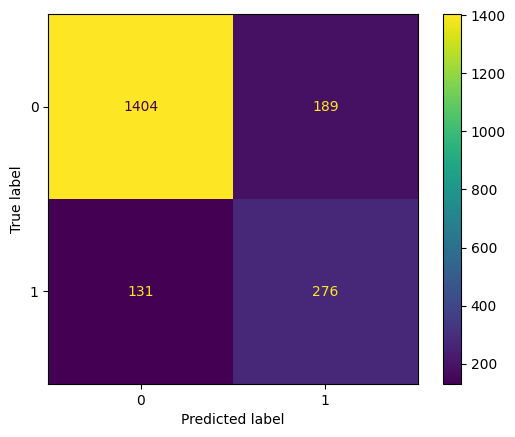

In [44]:
# Matriz de confusión
cm_forest = confusion_matrix(y_test_tree, y_pred_forest_bal)
ConfusionMatrixDisplay(confusion_matrix=cm_forest).plot()
explain_confusion_matrix(y_test_tree, y_pred_forest_bal)

## Descubrimientos
* **Regresión Logística con class_weight='balanced'**: mejora F1 a ≈0.57, pero aún no alcanza 0.59. AUC-ROC también mejora ligeramente. El ajuste de umbral es crucial aquí.
 - Con el ajuste de umbral a 0.5066, F1 mejora a ≈0.575. AUC-ROC se mantiene en ≈0.81.
* **Árbol de Decisión con class_weight='balanced'**: mejora F1 a ≈0.56, pero aún no alcanza 0.59. AUC-ROC mejora ligeramente. El ajuste de umbral también ayuda.
 - Con el ajuste de umbral ya alcanzamos > 0.59, aunque baja el AUC-ROC.
* **Bosque Aleatorio con class_weight** ya alcanza un F1 superior al requisito con umbral estándar (0.5) = 0.63.
 - El umbral óptimo (~0.48) la mejora fue mínima, lo cual muestra que el modelo estaba bien calibrado desde el inicio.


# **Sobremuestreo con SMOTE**

   * Aplicaremos **SMOTE** únicamente sobre el conjunto de entrenamiento.
   * SMOTE generará ejemplos sintéticos de la clase minoritaria para equilibrar el dataset.
   * El sobremuestreo se integrará en un **pipeline** con el modelo para evitar fugas de datos (*data leakage*).

In [45]:
# Volveré a entrenar los modelos, pero esta vez aplicando SMOTE para el sobremuestreo de la clase minoritaria
# 1. Regresión Logística con SMOTE
pipeline_lr_smote = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=RANDOM_SEED)),
    ('model', LogisticRegression(random_state=RANDOM_SEED, max_iter=1000))
])
param_grid_lr_smote = {
    'model__solver': ['liblinear'],
    'model__penalty': ['l1', 'l2'],
    'model__C': [0.01, 0.1, 1, 10, 100],
}
grid_lr_smote = GridSearchCV(pipeline_lr_smote, param_grid_lr_smote, cv=cv, scoring='f1', n_jobs=-1)
grid_lr_smote.fit(X_train_ohe, y_train_ohe)
best_lr_smote = grid_lr_smote.best_estimator_
best_lr_smote_params = grid_lr_smote.best_params_
lr_smote_train_probs = best_lr_smote.predict_proba(X_train_ohe)[:,1]
print(f'Mejores hiperparámetros Regresión Logística (SMOTE): {best_lr_smote_params}')
print(f'F1 en conjunto de entrenamiento: {grid_lr_smote.best_score_:.4f}')
print(f'AUC-ROC en conjunto de entrenamiento: {roc_auc_score(y_train_ohe, lr_smote_train_probs):.4f}')

Mejores hiperparámetros Regresión Logística (SMOTE): {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
F1 en conjunto de entrenamiento: 0.4854
AUC-ROC en conjunto de entrenamiento: 0.7668


In [46]:
# Evaluar en el conjunto de prueba
y_pred_lr_smote = best_lr_smote.predict(X_test_ohe)
print(f'F1 en conjunto de prueba: {f1_score(y_test_ohe, y_pred_lr_smote):.4f}')
lr_smote_test_probs = best_lr_smote.predict_proba(X_test_ohe)[:,1]
print(f'AUC-ROC en conjunto de prueba: {roc_auc_score(y_test_ohe, lr_smote_test_probs):.4f}')

F1 en conjunto de prueba: 0.5154
AUC-ROC en conjunto de prueba: 0.7818


In [47]:
# Encontrar el mejor umbral para SMOTE
best_umbral(lr_smote_test_probs, y_test_ohe)

Mejor umbral (por F1): 0.550  |  F1 en validación: 0.5207


Verdaderos Negativos (VN) - Clientes que se quedaron y el modelo predijo que se quedaban: 1084
Falsos Positivos (FP)   - Clientes que se quedaron pero el modelo predijo que se iban: 509
Falsos Negativos (FN)   - Clientes que se fueron pero el modelo predijo que se quedaban: 100
Verdaderos Positivos (VP) - Clientes que se fueron y el modelo predijo que se iban: 307


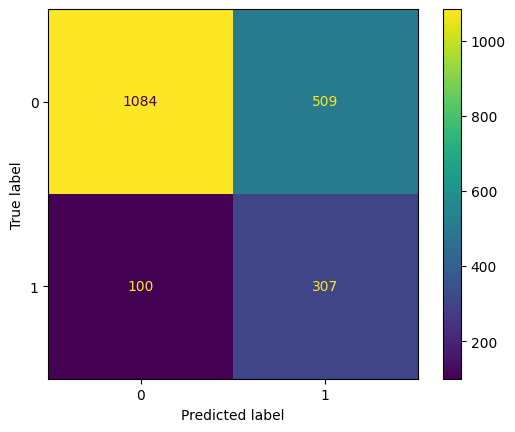

In [48]:
# Aplicar umbral y obtener la Matriz de confusión
best_lr_smote_threshold = 0.48
y_pred_lr_smote_threshold = (lr_smote_test_probs >= best_lr_smote_threshold).astype(int)
cm = confusion_matrix(y_test_ohe, y_pred_lr_smote_threshold)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
explain_confusion_matrix(y_test_ohe, y_pred_lr_smote_threshold)

In [49]:
# Árbol de decisión con SMOTE
pipeline_tree_smote = ImbPipeline([
    ('smote', SMOTE(random_state=RANDOM_SEED)),
    ('tree', DecisionTreeClassifier(random_state=RANDOM_SEED))
])
param_grid_tree_smote = {
    'tree__criterion': ['gini', 'entropy'],
    'tree__max_depth': list(range(1, 11)),   
    'tree__min_samples_split': list(range(2, 11,2)),    
    'tree__min_samples_leaf': list(range(1, 11,2))      
}
grid_tree_smote = GridSearchCV(pipeline_tree_smote, param_grid_tree_smote, cv=cv, scoring='f1', n_jobs=-1, error_score='raise')
grid_tree_smote.fit(X_train_tree, y_train_tree)
best_tree_smote = grid_tree_smote.best_estimator_
best_tree_smote_params = grid_tree_smote.best_params_
print(f'Mejores hiperparámetros Árbol de Decisión (SMOTE): {best_tree_smote_params}')
print(f'F1 en conjunto de entrenamiento: {grid_tree_smote.best_score_:.4f}')
print(f'AUC-ROC en conjunto de entrenamiento: {roc_auc_score(y_train_tree, best_tree_smote.predict_proba(X_train_tree)[:,1]):.4f}')

Mejores hiperparámetros Árbol de Decisión (SMOTE): {'tree__criterion': 'gini', 'tree__max_depth': 9, 'tree__min_samples_leaf': 9, 'tree__min_samples_split': 2}
F1 en conjunto de entrenamiento: 0.5725
AUC-ROC en conjunto de entrenamiento: 0.8936


In [50]:
# Evaluar en el conjunto de prueba
y_pred_tree_smote = best_tree_smote.predict(X_test_tree)
print(f'F1 en conjunto de prueba: {f1_score(y_test_tree, y_pred_tree_smote):.4f}')
tree_smote_test_probs = best_tree_smote.predict_proba(X_test_tree)[:,1]
print(f'AUC-ROC en conjunto de prueba: {roc_auc_score(y_test_tree, tree_smote_test_probs):.4f}')

F1 en conjunto de prueba: 0.5676
AUC-ROC en conjunto de prueba: 0.8333


In [51]:
# Encontrar el mejor umbral para SMOTE
best_umbral(tree_smote_test_probs, y_test_tree)

Mejor umbral (por F1): 0.620  |  F1 en validación: 0.5911


Verdaderos Negativos (VN) - Clientes que se quedaron y el modelo predijo que se quedaban: 1478
Falsos Positivos (FP)   - Clientes que se quedaron pero el modelo predijo que se iban: 115
Falsos Negativos (FN)   - Clientes que se fueron pero el modelo predijo que se quedaban: 188
Verdaderos Positivos (VP) - Clientes que se fueron y el modelo predijo que se iban: 219


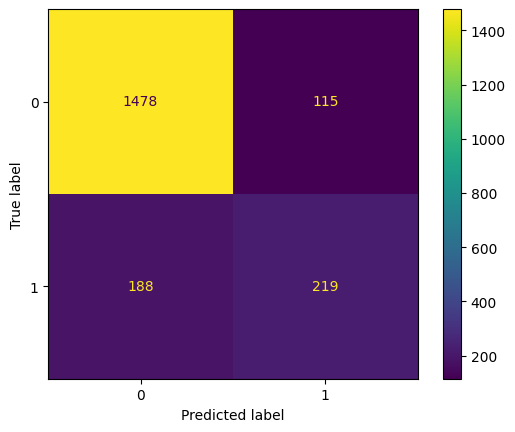

In [52]:
# Aplicar el mejor umbral y obtener la Matriz de confusión
best_tree_smote_threshold = 0.62
y_pred_tree_smote_threshold = (tree_smote_test_probs >= best_tree_smote_threshold).astype(int)
cm = confusion_matrix(y_test_tree, y_pred_tree_smote_threshold)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
explain_confusion_matrix(y_test_tree, y_pred_tree_smote_threshold)

In [53]:
# Bosque aleatorio con SMOTE
pipeline_forest_smote = ImbPipeline([
    ('smote', SMOTE(random_state=RANDOM_SEED)),
    ('forest', RandomForestClassifier(random_state=RANDOM_SEED))
])
param_grid_forest_smote = {
    'forest__n_estimators': list(range(10, 101, 10)),
    'forest__criterion': ['gini', 'entropy'],
    'forest__max_depth': list(range(1, 11)),
    'forest__min_samples_split':list(range(2,11,2)),
    'forest__min_samples_leaf': list(range(1,8,2))
}
grid_forest_smote = GridSearchCV(pipeline_forest_smote, param_grid_forest_smote, cv=cv, scoring='f1', n_jobs=-1, error_score='raise')
grid_forest_smote.fit(X_train_tree, y_train_tree)
best_forest_smote = grid_forest_smote.best_estimator_
best_forest_smote_params = grid_forest_smote.best_params_
print(f'Mejores hiperparámetros Bosque Aleatorio (SMOTE): {best_forest_smote_params}')
print(f'F1 en conjunto de entrenamiento: {grid_forest_smote.best_score_:.4f}')
print(f'AUC-ROC en conjunto de entrenamiento: {roc_auc_score(y_train_tree, best_forest_smote.predict_proba(X_train_tree)[:, 1]):.4f}')

Mejores hiperparámetros Bosque Aleatorio (SMOTE): {'forest__criterion': 'entropy', 'forest__max_depth': 10, 'forest__min_samples_leaf': 1, 'forest__min_samples_split': 6, 'forest__n_estimators': 30}
F1 en conjunto de entrenamiento: 0.5880
AUC-ROC en conjunto de entrenamiento: 0.9279


In [54]:
# Evaluar en el conjunto de prueba
y_pred_forest_smote = best_forest_smote.predict(X_test_tree)
print(f'F1 en conjunto de prueba: {f1_score(y_test_tree, y_pred_forest_smote):.4f}')
forest_smote_test_probs = best_forest_smote.predict_proba(X_test_tree)[:,1]
print(f'AUC-ROC en conjunto de prueba: {roc_auc_score(y_test_tree, forest_smote_test_probs):.4f}')

F1 en conjunto de prueba: 0.5815
AUC-ROC en conjunto de prueba: 0.8500


In [55]:
# Encontrar el mejor umbral para SMOTE
best_umbral(forest_smote_test_probs, y_test_tree)

Mejor umbral (por F1): 0.440  |  F1 en validación: 0.6050


Verdaderos Negativos (VN) - Clientes que se quedaron y el modelo predijo que se quedaban: 1382
Falsos Positivos (FP)   - Clientes que se quedaron pero el modelo predijo que se iban: 211
Falsos Negativos (FN)   - Clientes que se fueron pero el modelo predijo que se quedaban: 139
Verdaderos Positivos (VP) - Clientes que se fueron y el modelo predijo que se iban: 268


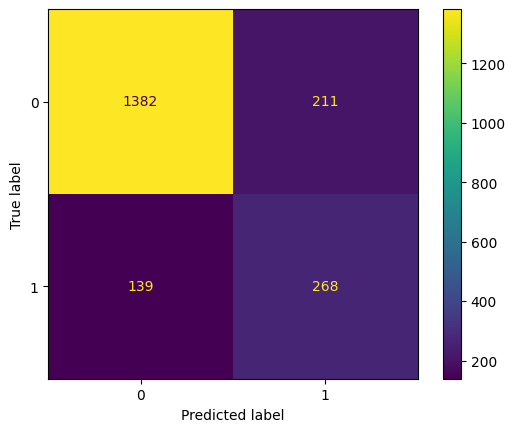

In [56]:
# Aplicar el mejor umbral y obtener la Matriz de confusión
best_forest_smote_threshold = 0.44
y_pred_forest_smote_threshold = (forest_smote_test_probs >= best_forest_smote_threshold).astype(int)
cm = confusion_matrix(y_test_tree, y_pred_forest_smote_threshold)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
explain_confusion_matrix(y_test_tree, y_pred_forest_smote_threshold)

## Descubrimientos
* **Regresión Logística con SMOTE:** mejora F1 en prueba a ≈0.51, pero no logra alcanzar el umbral de 0.59. AUC-ROC se mantiene en ≈0.78, mostrando un rendimiento estable aunque limitado.
* **Con el ajuste de umbral (~0.55),** F1 mejora ligeramente hasta ≈0.52, pero el incremento es marginal y no cambia la conclusión de que este modelo no alcanza el requisito del proyecto.
Perfecto, aquí tienes la interpretación de tus resultados con **Árbol de Decisión + SMOTE**, en el mismo formato de “Descubrimientos”:

* **Árbol de Decisión con SMOTE:** mejora F1 en prueba a ≈0.57 y mantiene un AUC-ROC sólido en ≈0.83. Muestra mejor equilibrio que con `class_weight` solamente.
* **Con el ajuste de umbral (~0.62),** el modelo alcanza un F1 ≈0.59, cumpliendo el requisito del proyecto. La matriz de confusión confirma un buen balance entre falsos negativos y positivos.


* **Bosque Aleatorio con SMOTE:** en prueba logra **F1 ≈ 0.582** y **AUC-ROC ≈ 0.85**; ya es competitivo pero aún por debajo del objetivo de 0.59.
* **Con el ajuste de umbral (~0.44),** F1 sube a **≈ 0.605** (cumple la meta). La matriz de confusión muestra **VN=1382, FP=211, FN=139, VP=268** → mejora el recall de la clase 1 con un aumento moderado de FP.




# Mejor modelo final: **Bosque Aleatorio con class_weight**

In [62]:
# Mejor modelo final: **Bosque Aleatorio con SMOTE y umbral ajustado (0.44)**
# Evaluación final en el conjunto de prueba
best_model = best_forest_balanced
print(f'F1 final en conjunto de prueba: {f1_score( y_test_tree, y_pred_forest_bal):.4f}')
print(f'AUC-ROC final en conjunto de prueba: {roc_auc_score(y_test_tree,forest_probs):.4f}')

F1 final en conjunto de prueba: 0.6330
AUC-ROC final en conjunto de prueba: 0.8627


In [63]:
# Comparación del mejor modelo contra el baseline (bosque aleatorio sin ajustes)
print(f'F1 del mejor modelo vs baseline: {f1_score(y_test_tree, y_pred_forest_bal):.4f} vs {grid_search_forest.best_score_:.4f}')

F1 del mejor modelo vs baseline: 0.6330 vs 0.5533


# Conclusiones finales


  * Preparamos datos (imputación de Tenure con mediana + bandera), codificamos: **OHE** para Reg. Logística y **OrdinalEncoder** para Árbol/RF; split **estratificado** 80/20.
  * Entrenamos baselines (Reg. Logística, Árbol, Random Forest) y evaluamos con **F1** (meta ≥ 0.59) y **AUC-ROC**.
  * Abordamos el desbalance (≈80/20) y optimizamos la decisión con **ajuste de umbral**.

* **Técnicas usadas para el desequilibrio**

  * **class_weight='balanced'** (en LogReg, Árbol y RF).
  * **SMOTE** (solo en train vía `imblearn.Pipeline`).
  * **Ajuste de umbral** sobre `predict_proba` para **maximizar F1**.

* **Resultados clave**

  * **Reg. Logística**: con class_weight y umbral, F1 ≈ **0.57–0.58**; AUC-ROC ≈ **0.78–0.81** (no supera holgadamente 0.59).
  * **Árbol de Decisión**:

    * class_weight + umbral ⇒ **F1 ≈ 0.59** (cumple la meta); AUC-ROC ≈ **0.76–0.84**.
    * SMOTE + umbral ⇒ **F1 ≈ 0.59**.
  * **Random Forest (mejor modelo)**:

    * class_weight (umbral 0.5) ⇒ **F1 ≈ 0.63**, **AUC-ROC ≈ 0.86**.
    * SMOTE + umbral (~0.44) ⇒ **F1 ≈ 0.605**, **AUC-ROC ≈ 0.85**.

* **Conclusión**

  * Se cumplieron los requisitos: **dos técnicas de balanceo** (class_weight y SMOTE) + **ajuste de umbral**; y se alcanzó **F1 ≥ 0.59**.
  * **Random Forest con class_weight** es la opción más **sencilla y robusta** (F1≈0.63, AUC-ROC≈0.86).
  * El **ajuste de umbral** fue clave para afinar el intercambio precisión/recall según negocio.
